<a href="https://colab.research.google.com/github/h0806449f/TensorFlow/blob/main/Tibame_TensorFlow_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sobel
1. 3*3 以某像素為中心, 擷取特徵
2. 為何是3*3 : GPU 優化處理過
3. 為何不用5*5 ... : 利用深度替代
4. 如何擷取特徵 : 透過9個數值差, 來強調`邊緣`

In [1]:
from urllib.request import urlretrieve

url = "https://github.com/Elwing-Chou/tibaml0315/raw/main/bg%20morning.png"
urlretrieve(url, "test.png")

('test.png', <http.client.HTTPMessage at 0x7f55de651990>)

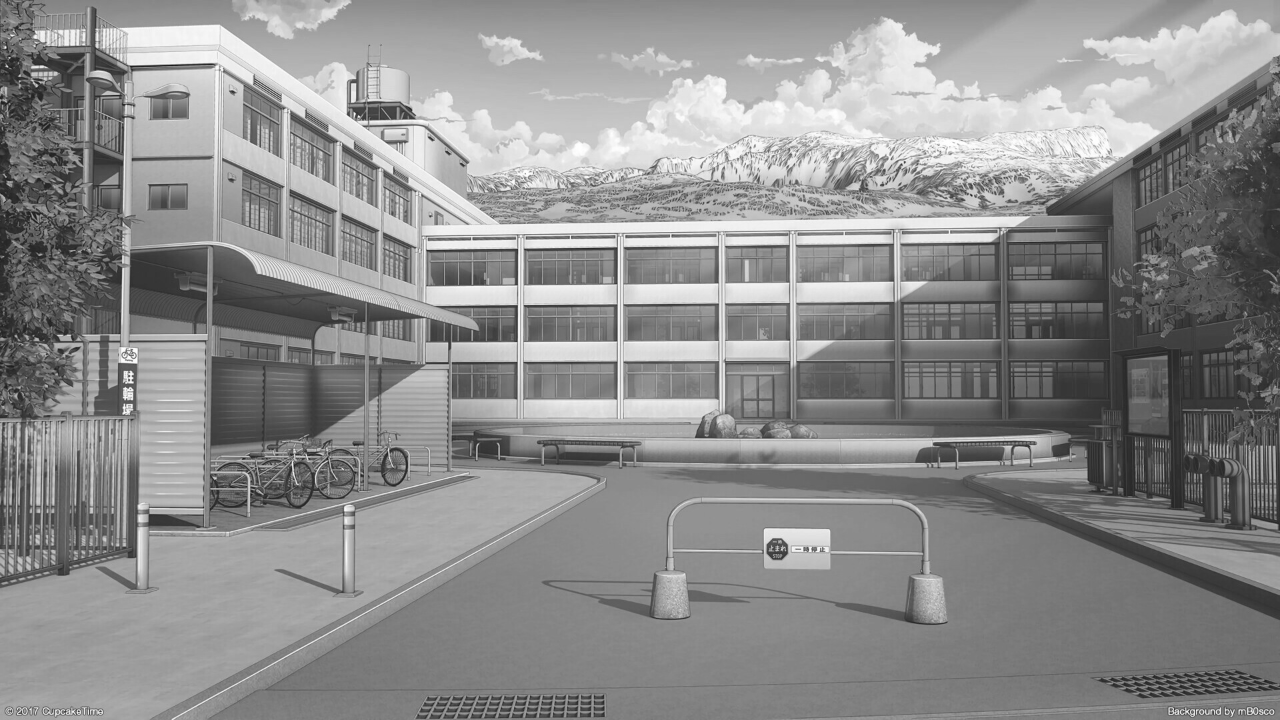

In [2]:
import numpy as np
from PIL import Image

img = Image.open("test.png").convert("L")
img_np = np.array(img)
img

In [3]:
img_np.shape

(720, 1280)

In [4]:
# Gx  (直線)

Gx = [
    [1, 0, -1],
    [2, 0, -2],
    [1, 0, -1]
]

def combine(img, ci, cj, g):
    # ci, cj: center -1: top left
    si, sj = ci-1, cj-1
    total = 0.0
    for i in range(3):
        for j in range(3):
            total = total + img[si+i][sj+j] * g[i][j]
    return abs(total)

img_gx = np.zeros(img_np.shape)
h, w = img_np.shape
for i in range(1, h-1):
    for j in range(1, w-1):
        img_gx[i][j] = combine(img_np, i, j, Gx)

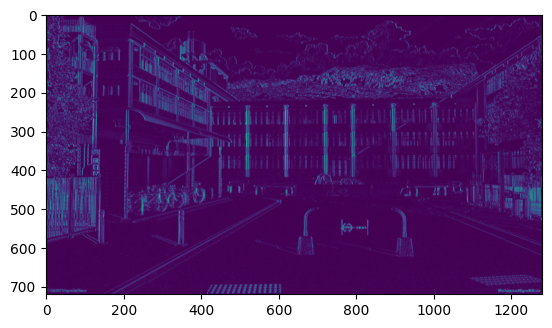

In [5]:
import matplotlib.pyplot as plt

# 0~255(ok) 0.0~1.0(ok)
# 0~1: (pi - min) / (max - min)
ma = img_gx.max()
mi = img_gx.min()
img_norm = (img_gx - mi) / (ma - mi)
plt.imshow(img_norm)

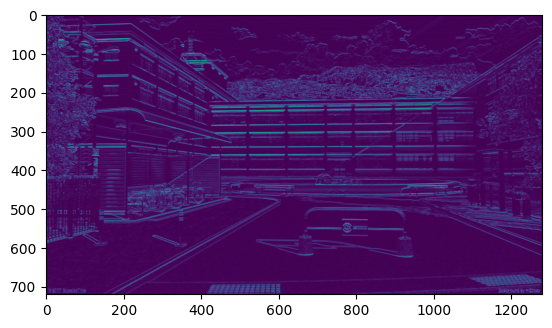

In [6]:
# Gy  (橫線)

Gy = [
    [1, 2, 1],
    [0, 0, 0],
    [-1, -2, -1]
]

img_gy = np.zeros(img_np.shape)
h, w = img_np.shape
for i in range(1, h-1):
    for j in range(1, w-1):
        img_gy[i][j] = combine(img_np, i, j, Gy)

ma = img_gy.max()
mi = img_gy.min()
img_norm = (img_gy - mi) / (ma - mi)
plt.imshow(img_norm)

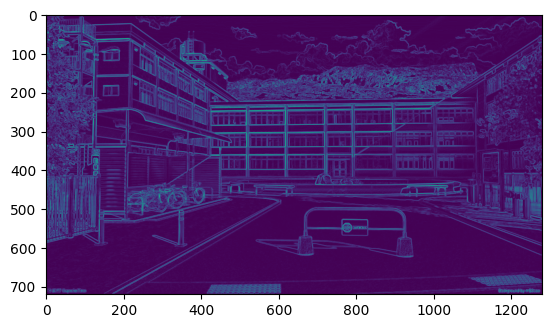

In [7]:
#　Gx + Gy

img_g = (img_gx ** 2 + img_gy ** 2) ** 0.5
ma = img_g.max()
mi = img_g.min()
img_norm = (img_g - mi) / (ma - mi)
plt.imshow(img_norm)

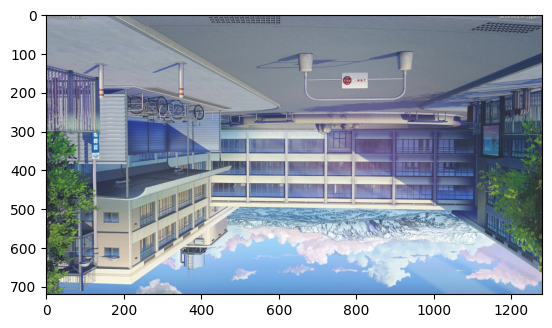

In [8]:
# 圖像操作  (np.array操作 -> 對某一個軸, 都進行一個list操作)

img = Image.open("test.png").convert("RGB")
img_np = np.array(img)

# 左右相反
plt.imshow(img_np[:, ::-1, :])

# 上下相反
plt.imshow(img_np[::-1, :, :])

# CIFAR 10


In [9]:
# import datasets

from tensorflow.keras.datasets import cifar10
( (x_train, y_train), (x_test, y_test) ) = cifar10.load_data()

170498071/170498071 [==============================] - 13s 0us/step


In [10]:
# check shape

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

In [13]:
# (50000, 1) 原資料型態是為了未來擴充達案的可能性, 這邊不需要, 所以reshape

y_train = y_train.reshape(50000)
y_test = y_test.reshape(10000)

In [15]:
# 轉換答案的list
trans = [ 
    "airplane",										
    "automobile",										
    "bird",										
    "cat",										
    "deer",										
    "dog",										
    "frog",										
    "horse",										
    "ship",										
    "truck"
]

dog


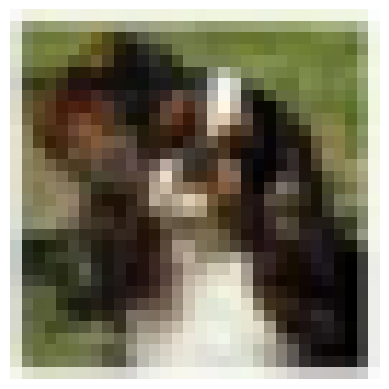

In [20]:
# check image

from PIL import Image
index = 500
plt.imshow(x_train[index])
plt.axis("off")

print(trans[y_train[index]])

In [21]:
# build model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

layers = [
    Conv2D(64, 3, padding="same", activation="relu", input_shape=(32, 32, 3)),
    MaxPooling2D(),
    Conv2D(128, 3, padding="same", activation="relu"),
    MaxPooling2D(),
    Conv2D(256, 3, padding="same", activation="relu"),
    MaxPooling2D(),
    GlobalAveragePooling2D(),
    Dense(10, activation="softmax")
]

model = Sequential(layers)
model.summary()

# summary 解析
# filter 3 * 3   RGB 3
# conv 64
# 27 * 64 + 64 = 1792 

# filter 3 * 3   64
# conv 128
# 576 * 128 + 128 = 73856

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 128)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 256)         295168    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 256)        0

In [22]:
# 問題集 預處理

x_train_norm = x_train / 255.0
x_test_norm = x_test / 255.0

In [ ]:
# 答案集 預處理

In [23]:
# compile
# 避免分類太多而消耗過多的RAM
from tensorflow.keras.losses import SparseCategoricalCrossentropy


model.compile(loss=SparseCategoricalCrossentropy(),
        metrics=["accuracy"],
        optimizer="adam")

In [24]:
# fit
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


c = [
    ModelCheckpoint("cnn.h5", save_best_only=True),
    EarlyStopping(patience=5, restore_best_weights=True)
]
model.fit(x_train_norm,
     y_train,
     batch_size=100,
     epochs=40,
     validation_split=0.1,
     callbacks=c)

Epoch 1/40
450/450 [==============================] - 14s 9ms/step - loss: 1.7377 - accuracy: 0.3537 - val_loss: 1.4818 - val_accuracy: 0.4592
Epoch 2/40
450/450 [==============================] - 4s 8ms/step - loss: 1.4075 - accuracy: 0.4952 - val_loss: 1.3160 - val_accuracy: 0.5254
Epoch 3/40
450/450 [==============================] - 4s 9ms/step - loss: 1.2458 - accuracy: 0.5552 - val_loss: 1.1958 - val_accuracy: 0.5690
Epoch 4/40
450/450 [==============================] - 4s 8ms/step - loss: 1.1440 - accuracy: 0.5945 - val_loss: 1.0844 - val_accuracy: 0.6238
Epoch 5/40
450/450 [==============================] - 4s 8ms/step - loss: 1.0547 - accuracy: 0.6301 - val_loss: 1.0088 - val_accuracy: 0.6506
Epoch 6/40
450/450 [==============================] - 4s 9ms/step - loss: 0.9933 - accuracy: 0.6513 - val_loss: 1.0451 - val_accuracy: 0.6326
Epoch 7/40
450/450 [==============================] - 5s 12ms/step - loss: 0.9366 - accuracy: 0.6729 - val_loss: 0.9306 - val_accuracy: 0.6812
Epoc

In [25]:
model.evaluate(x_test_norm, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.6997 - accuracy: 0.7646


[0.6997231245040894, 0.7645999789237976]

In [27]:
import pandas as pd
from sklearn.metrics import confusion_matrix

pre = model.predict(x_test_norm).argmax(axis=1)
mat = confusion_matrix(y_test, pre)
pd.DataFrame(mat,
       index=["{}(true)".format(trans[i]) for i in range(10)],
       columns=["{}(pred)".format(trans[i]) for i in range(10)])

313/313 [==============================] - 1s 3ms/step


,airplane(pred),automobile(pred),bird(pred),cat(pred),deer(pred),dog(pred),frog(pred),horse(pred),ship(pred),truck(pred)
airplane(true),807,17,49,14,8,7,5,11,58,24
automobile(true),21,877,1,9,0,2,4,2,19,65
bird(true),57,2,700,51,53,43,54,23,8,9
cat(true),20,7,84,608,45,119,44,43,17,13
deer(true),15,2,79,46,713,24,39,71,11,0
dog(true),10,5,44,183,41,623,12,57,16,9
frog(true),6,6,49,82,38,24,777,9,7,2
horse(true),10,0,30,40,45,33,2,826,2,12
ship(true),54,20,10,13,1,1,4,5,865,27
truck(true),24,71,8,13,3,3,0,9,19,850


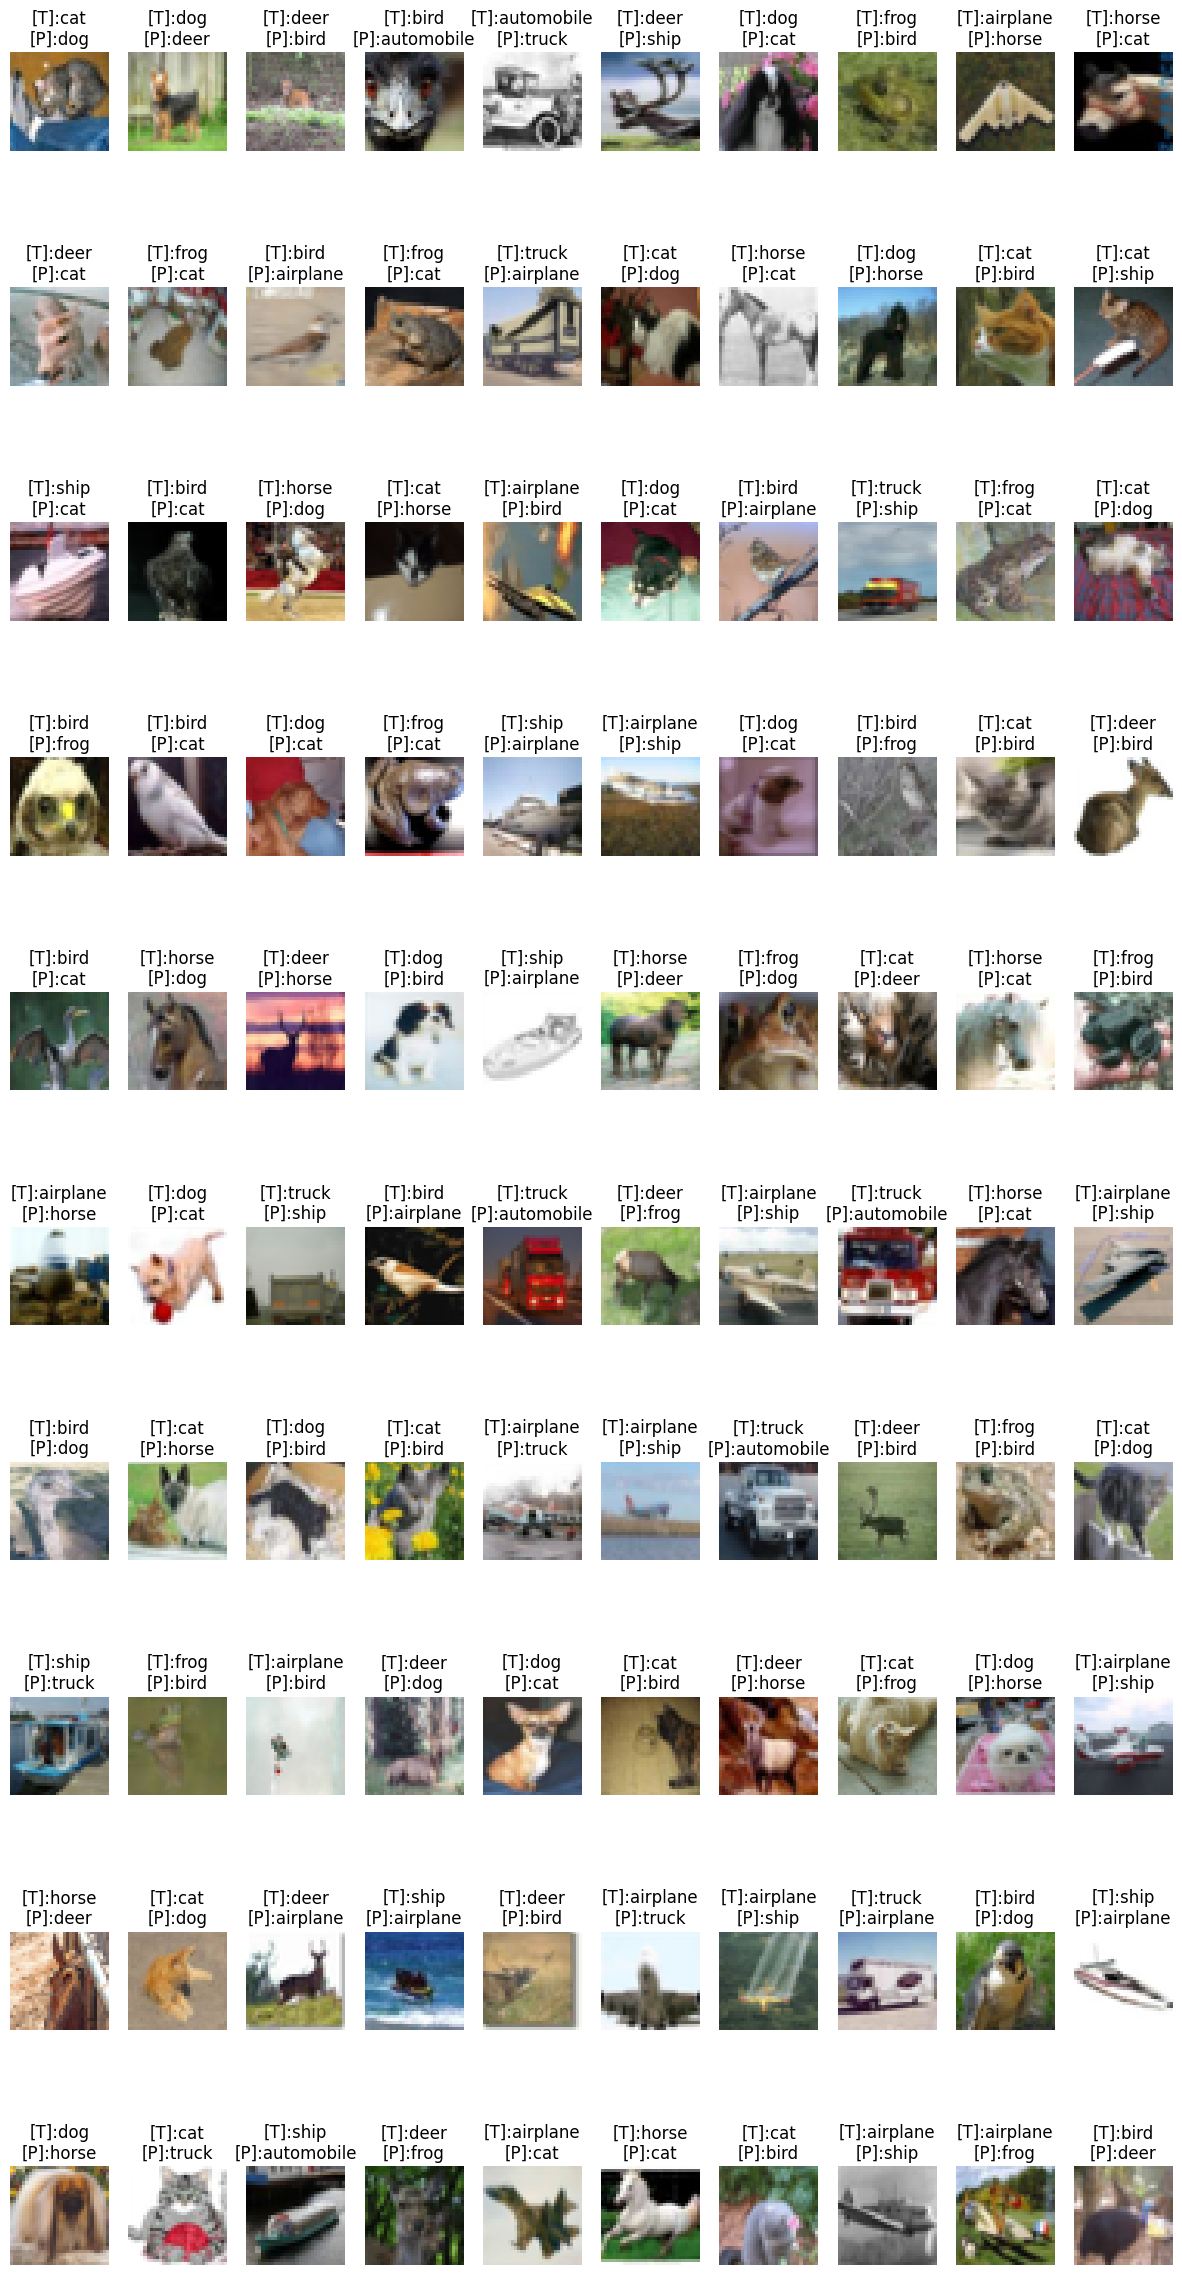

In [28]:
import numpy as np
idx = np.nonzero(y_test != pre)[0]
idx = idx[:100]
plt.figure(figsize=(15, 30))
# 預測錯誤的預測值
fp_pred = pre[idx]
# 預測錯誤的真實值
fp_true = y_test[idx]
# 預測錯誤的圖片
fp_img = x_test[idx]
for i in range(len(idx)):
    plt.subplot(10, 10, i+1)
    plt.axis("off")
    t = "[T]:{}\n[P]:{}".format(trans[fp_true[i]], trans[fp_pred[i]])
    plt.title(t)
    plt.imshow(fp_img[i])